In [1]:
# This program generates a (S,R) Inventory restocking policy,
# R = Restocking level when an order is activated
# S = Stock level that wants to be achieved.
# This model can have only 1 order at a time

# This is also restricted by the number of resources available to perform the work
#   1) Receive goods at the warehouse
#   2) Delver goods to the Customers
#   3) Put order into the system

# Based on:
# https://www.youtube.com/watch?v=Kmu9DNQamLw

# Daniel A. Sepulveda Estay, PhD
# Technical University of Denmark, 200310

import simpy
import numpy as np

In [2]:
# Define the variables of the model
lead_time = 2.0  # Lead_time for orders of #num_ordered
cost_ordering = 50  # Cost of making an order
cost_holding = 100 # Copst of Holding inventory
policy_cutoff = 20 # Minimum amount of stock when an order is activated
policy_inventory_target = 50 # Amount of stock that can be maintained in the Warehouse

# Define the processes in the Model
# 1.- The warehouse process which considers 
#    a) the arrival time of a new order, 
#    b) calculation of holding costs
#    c) the demand quantity for that new order
#    d) Deliver the demad quantity as much as possible
#    e) generation of order if inventory is below the cutoff quantity

def warehouse_run(env, order_cutoff, order_target):
    
    global inventory, balance, num_ordered
    inventory = order_target
    balance = 0.0
    num_ordered = 0
    
    while True:
        # a) Generate arrival time of next customer demand (Exponential Distribution Function)
        interarrival = generate_interarrival()
        # Wait until this arrival time
        yield env.timeout(interarrival)
        # b) Calculate the holding costs 
        balance -= inventory*2*interarrival
        # c) Generate a demand quantity (Uniform Distribution Function)
        demand = generate_demand()
        # d) Deliver inventory for cases where there is enouh ibnventory and where there is not enough
        if demand<inventory:
            balance += 100*demand
            inventory -= demand
            print('at time {:.2f} days we sold {} units'.format(env.now, demand))
        else:
            balance += cost_holding*inventory
            print('At time {:.2f} days we sold {} units. Out of Stock'.format(env.now, inventory))
            inventory = 0
        # e) See if it is necessary to generate a new order (Function)  
        if inventory < order_cutoff and num_ordered==0:
            env.process(handle_order(env, order_target))
    
def handle_order(env, order_target):
    global inventory, balance, num_ordered
    # Order stock necessary to cover the difference from the policy_inventory_target
    num_ordered = order_target - inventory
    print('at time {:.2f} placed order for {} units'.format(env.now, num_ordered))
    # Calculate and account the cost of ordering
    balance -= cost_ordering*num_ordered
    # wait the lead time for orders, of lead_time time units
    yield env.timeout(lead_time)
    #receive the order by increasing the inventory
    inventory += num_ordered
    print('at time {:.2f} order received for {} units'.format(env.now, inventory))
    # leave the system ready for a new order
    num_ordered = 0
    
    
def generate_interarrival():
    # The arrivals of new customers is expenential with a lambda=5 persons/time
    return np.random.exponential(1./5.0)

def generate_demand():
    return np.random.randint(1,5) # value integrer between 1 and 5 units/time

# Define the observational variables
obs_time = []
inventory_level = [] # This balance starts at policy_inventory_target units of inventory
balance_level = []  # This balance level starts at 0 units of money

def observe(env):
    global inventory, balance
    
    while True:
        obs_time.append(env.now)
        inventory_level.append(inventory)
        balance_level.append(balance)
        yield env.timeout(0.1)
        

In [4]:
np.random.seed(1)
env = simpy.Environment()
env.process(warehouse_run(env, policy_cutoff, 50))
env.process(observe(env))
env.run(until=5.0)

at time 0.11 days we sold 1 units
at time 0.65 days we sold 2 units
at time 0.72 days we sold 4 units
at time 0.77 days we sold 2 units
at time 0.81 days we sold 2 units
at time 1.04 days we sold 2 units
at time 1.19 days we sold 3 units
at time 1.27 days we sold 1 units
at time 1.31 days we sold 3 units
at time 1.36 days we sold 3 units
at time 1.59 days we sold 4 units
at time 1.71 days we sold 2 units
at time 1.74 days we sold 1 units
at time 2.04 days we sold 2 units
at time 2.04 placed order for 32 units
at time 2.73 days we sold 4 units
at time 2.75 days we sold 2 units
at time 3.17 days we sold 1 units
at time 3.52 days we sold 1 units
at time 3.53 days we sold 4 units
at time 3.54 days we sold 1 units
at time 3.56 days we sold 4 units
At time 3.78 days we sold 1 units. Out of Stock
At time 3.94 days we sold 0 units. Out of Stock
At time 4.00 days we sold 0 units. Out of Stock
at time 4.04 order received for 32 units
at time 4.24 days we sold 1 units
at time 4.34 days we sold 4 

<function matplotlib.pyplot.show(*args, **kw)>

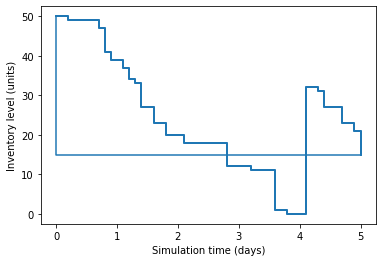

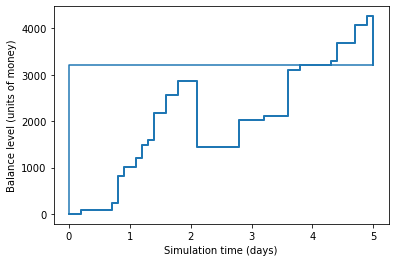

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.step(obs_time, inventory_level, where='post')
plt.xlabel('Simulation time (days)')
plt.ylabel('Inventory level (units)')
plt.show

plt.figure()
plt.step(obs_time, balance_level, where='post')
plt.xlabel('Simulation time (days)')
plt.ylabel('Balance level (units of money)')
plt.show

In [6]:
balance

3205.651093315541